 # 🎬 Netflix Data Analysis & Visualization | EDA + ML Project 📊
## 📥Import libraries & Load dataset 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv("netflix_titles.csv")
df.dropna(subset=["description", "type"], inplace=True)
# Set Seaborn style
sns.set(style="whitegrid")
# Load dataset
df = pd.read_csv("netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


##  🧹Clean & Prepare the Data
- Handling null values
- Splitting multiple director/actor entries
- Formatting date columns


In [2]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [3]:
df.dropna(subset=["title", "type"], inplace=True)


In [4]:
type_counts = df['type'].value_counts()


 ### 🎨Visualization and 📊 Exploratory Data Analysis (EDA)
- Let’s explore content distribution, genres, countries, and more using beautiful visualizations.


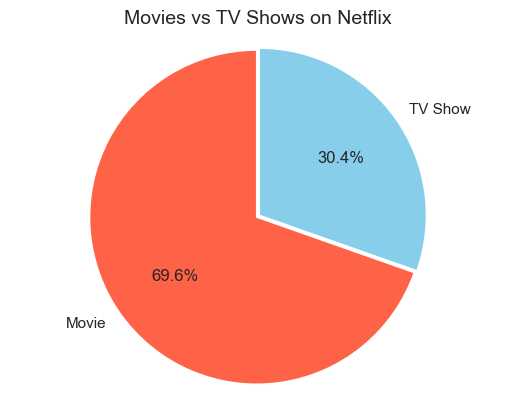

In [5]:
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', colors=['tomato', 'skyblue'], startangle=90, explode=(0.02, 0))
plt.title("Movies vs TV Shows on Netflix", fontsize=14)
plt.axis('equal')
plt.show()

C:\Users\Sharma Raj\AppData\Local\Temp\ipykernel_14620\736100429.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette="pastel")


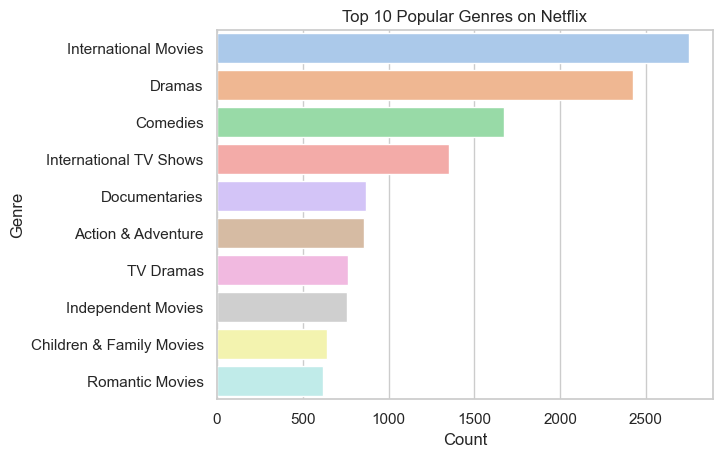

In [6]:
top_genres = df['listed_in'].dropna().str.split(', ').explode().value_counts().head(10)

sns.barplot(x=top_genres.values, y=top_genres.index, palette="pastel")
plt.title("Top 10 Popular Genres on Netflix")
plt.xlabel("Count"); plt.ylabel("Genre")
plt.show()


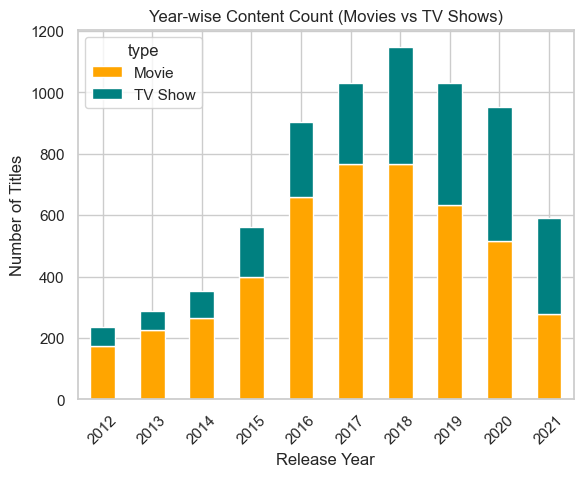

In [7]:
year_type = df.groupby(['release_year', 'type']).size().unstack().fillna(0)
year_type.tail(10).plot(kind='bar', stacked=True, color=['orange', 'teal'])
plt.title("Year-wise Content Count (Movies vs TV Shows)")
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")
plt.xticks(rotation=45)
plt.show()

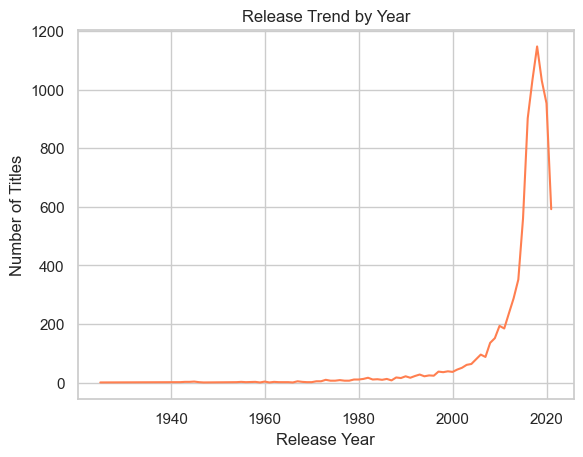

In [8]:
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')
sns.lineplot(data=df['release_year'].value_counts().sort_index(), color='coral')
plt.title("Release Trend by Year")
plt.xlabel("Release Year"); plt.ylabel("Number of Titles")
plt.show()

C:\Users\Sharma Raj\AppData\Local\Temp\ipykernel_14620\3314766084.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_directors, x='Count', y='Director', palette='Greens_r')


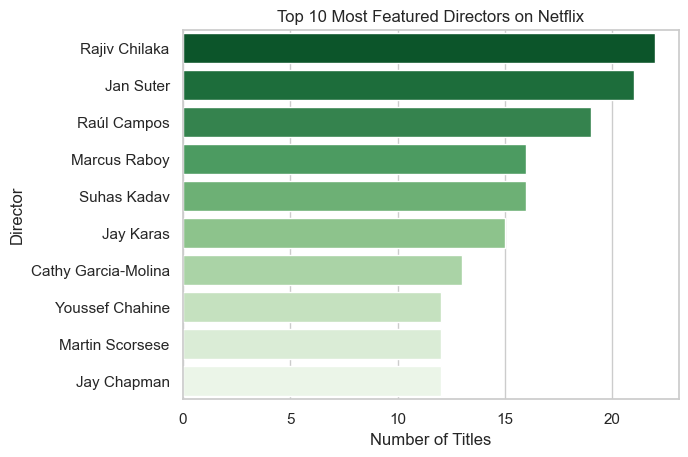

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

top_directors = df['director'].dropna().str.split(', ').explode().value_counts().head(10).reset_index()
top_directors.columns = ['Director', 'Count']
sns.barplot(data=top_directors, x='Count', y='Director', palette='Greens_r')
plt.title("Top 10 Most Featured Directors on Netflix")
plt.xlabel("Number of Titles")
plt.ylabel("Director")
plt.show()

## 🤖 Predicting Content Type using RandomForestClassifier & ✅ Accuracy & Performance Metrics

I used a TF-IDF vectorizer on description and train a RandomForestClassifier model to classify between Movies and TV Shows.
Let’s evaluate the model with Accuracy, Precision, Recall, and F1-Score.



In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Text Vectorization
X = df['description'].fillna("")
y = df['type']
tfidf = TfidfVectorizer(stop_words='english', max_features=8000)
X_vec = tfidf.fit_transform(X)
# Step 2: Split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)
# Step 3: Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Step 4: Predict
y_pred = model.predict(X_test)
# Step 5: Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7446083995459705
Classification Report:
               precision    recall  f1-score   support

       Movie       0.75      0.95      0.84      1214
     TV Show       0.72      0.29      0.42       548

    accuracy                           0.74      1762
   macro avg       0.73      0.62      0.63      1762
weighted avg       0.74      0.74      0.71      1762



In [11]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_vec, y, cv=5, scoring='accuracy')
print("Cross-validation Accuracy scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-validation Accuracy scores: [0.75141884 0.74801362 0.72856332 0.73651334 0.75695627]
Mean Accuracy: 0.7442930797884031
